## Momentum

Momentum is described in our research by
- `M12M`: `T-12 to T-1` momentum
- `M6M`: `T-6 to T-1` momentum
- `M2M`: `T-2 to T-1` momentum
- `M2M Sector Neutral`: Sector neutralised `M2M` momentum

As with our other research, we consider the performance of each metric individually, and then combine the metrics into a composite score, which is normalised cross-sectionally every day.

In [19]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

# .env variables
db_url = os.getenv('DB_URL')
constituents_table = os.getenv('CONSTITUENTS_TABLE')
prices_table = os.getenv('PRICES_TABLE')

# connection to sql database
psql = create_engine(db_url)

In [20]:
# get historical monthly data

adjusted_monthly = pd.read_sql("""
    select
        *
    from
        adjusted_monthly
    """,
    psql
)

adjusted_monthly['adj_return'] = (
    adjusted_monthly.groupby('ticker')['adj_close']
    .transform(lambda x: np.log(x / x.shift(1)))
)
adjusted_monthly['adj_close_-1'] = (
    adjusted_monthly.groupby('ticker')['adj_close'].shift(1)
)
adjusted_monthly['adj_close_-2'] = (
    adjusted_monthly.groupby('ticker')['adj_close'].shift(2)
)
adjusted_monthly['adj_close_-6'] = (
    adjusted_monthly.groupby('ticker')['adj_close'].shift(6)
)
adjusted_monthly['adj_close_-12'] = (
    adjusted_monthly.groupby('ticker')['adj_close'].shift(12)
)
adjusted_monthly['adj_return_+1'] = (
    adjusted_monthly.groupby('ticker')['adj_return'].shift(-1)
)
adjusted_monthly = adjusted_monthly.dropna()

constituents = pd.read_sql(
    """
    select
        ticker, start_date, end_date, sector
    from
        constituents
    """,
    psql
).dropna(subset=['sector'])

constituents['start_date'] = pd.to_datetime(constituents['start_date'])

# keep the row with the latest start_date for each ticker
constituents_latest = (
    constituents
    .sort_values(['ticker', 'start_date'], ascending=[True, False])
    .drop_duplicates(subset='ticker', keep='first')
    .reset_index(drop=True)
)

constituents_latest = constituents[['ticker', 'sector']]

In [26]:
returns_and_const = adjusted_monthly.merge(constituents_latest, how = 'left', on = ['ticker'])
returns_and_const['date'] = pd.to_datetime(returns_and_const['date'])

Now calculate our momentum metrics

In [ ]:
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

returns_and_const = returns_and_const.sort_values(['ticker', 'date'])

returns_and_const['m12m'] = np.log(
    returns_and_const['adj_close_-1'] / returns_and_const['adj_close_-12']
)

returns_and_const['m6m'] = np.log(
    returns_and_const['adj_close_-1'] / returns_and_const['adj_close_-6']
)

returns_and_const['m2m'] = np.log(
    returns_and_const['adj_close_-1'] / returns_and_const['adj_close_-2']
)

returns_and_const = returns_and_const.dropna()

# z-scores are more presentable
for col in ['m12m', 'm6m', 'm2m']:
    returns_and_const[col] = returns_and_const.groupby('date')[col].transform(winsorize)
    returns_and_const[col] = returns_and_const.groupby('date')[col].transform(zscore)

returns_and_const['m2m_neutral'] = returns_and_const.groupby(['date', 'sector'])['m2m'].transform(
    lambda x: zscore(x)
)

Now consider the forward 1-month rank IC for each momentum factor.

In [47]:
momentum_factors = ['m12m', 'm6m', 'm2m', 'm2m_neutral']

momentum_ic = []

for date, data in returns_and_const.groupby('date'):
    for f in momentum_factors:
        ic = data[f].corr(data['adj_return_+1'], method = 'spearman')
        momentum_ic.append({
            'date': date,
            'ic': ic,
            'factor': f
        })
momentum_ic_df = pd.DataFrame(momentum_ic)

momentum_ic_df['5_year_rolling_ic'] = momentum_ic_df.groupby('factor')['ic'].transform(
    lambda x: x.rolling(12 * 5).mean()
)
momentum_ic_df = momentum_ic_df.dropna()

Text(0.5, 0, 'Date')

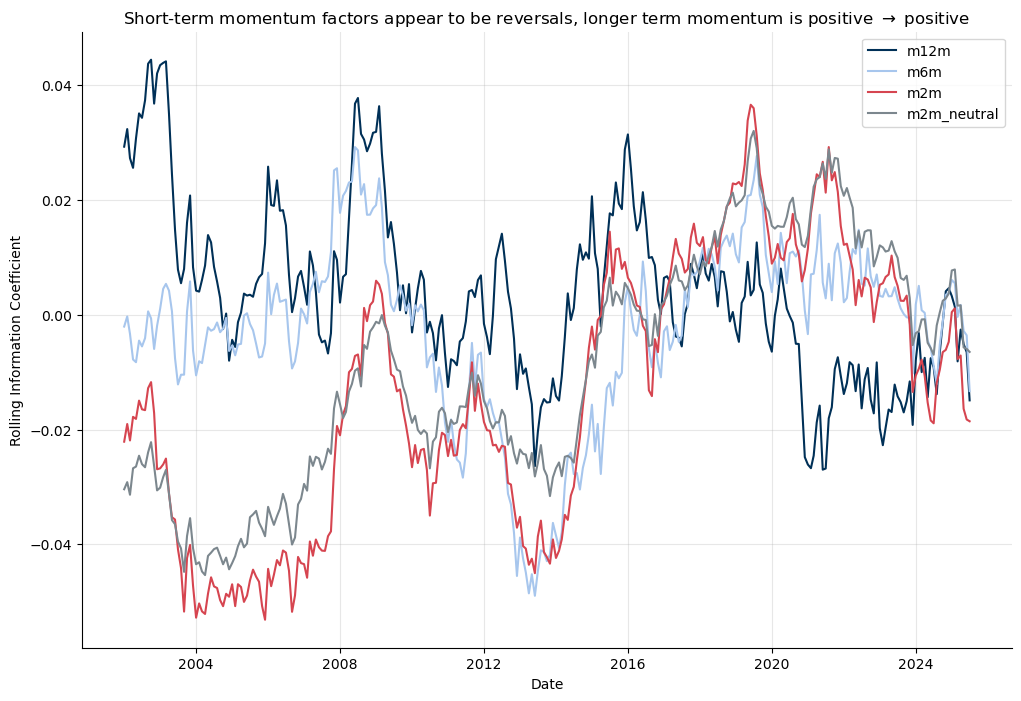

In [56]:
gs_colors = ['#003057', '#A7C6ED', '#D64550', '#7C878E', '#D9D9D6']

plt.figure(figsize=(12, 8))
plt.grid(alpha=0.3)

for i, f in enumerate(momentum_factors):
    f_data = momentum_ic_df[momentum_ic_df['factor'] == f]
    plt.plot(
        f_data['date'], 
        f_data['5_year_rolling_ic'], 
        label=f, 
        color=gs_colors[i % len(gs_colors)]
    )

plt.legend()
sns.despine()
plt.title('Short-term momentum factors appear to be reversals, longer term momentum is positive $\\to$ positive')
plt.ylabel('Rolling Information Coefficient')
plt.xlabel('Date')

Indeed in the paper `'Short-term momentum (almost) everywhere'` by Zaremba, Long et.al, they see short-term momentum reversals for `T-2 to T-1` signals which is our `M2M` signal. For the usage in our model, we flip the signals such to have `positive signal = long`.

In [ ]:
returns_and_const['m2m'] = -returns_and_const['m2m']
returns_and_const['m2m_neutral'] = -returns_and_const['m2m_neutral']

# re-calculate ic with flipped signals

momentum_factors = ['m12m', 'm6m', 'm2m', 'm2m_neutral']

momentum_ic = []

for date, data in returns_and_const.groupby('date'):
    for f in momentum_factors:
        ic = data[f].corr(data['adj_return_+1'], method = 'spearman')
        momentum_ic.append({
            'date': date,
            'ic': ic,
            'factor': f
        })
momentum_ic_df = pd.DataFrame(momentum_ic)

momentum_ic_df['5_year_rolling_ic'] = momentum_ic_df.groupby('factor')['ic'].transform(
    lambda x: x.rolling(12 * 5).mean()
)
momentum_ic_df = momentum_ic_df.dropna()

Text(0.5, 0, 'Date')

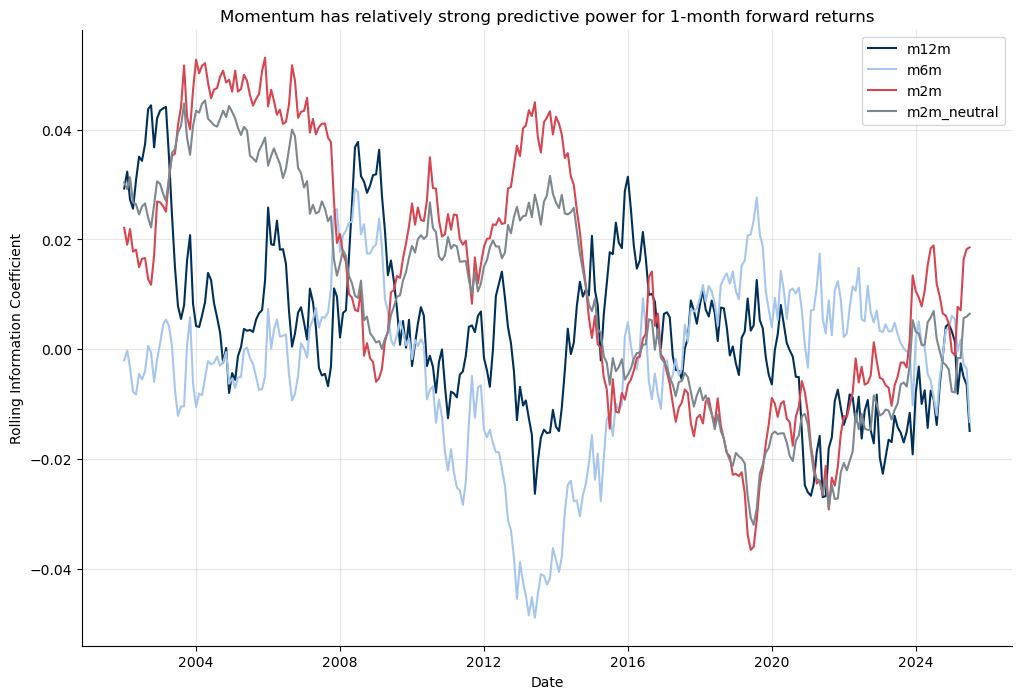

In [61]:
gs_colors = ['#003057', '#A7C6ED', '#D64550', '#7C878E', '#D9D9D6']

plt.figure(figsize=(12, 8))
plt.grid(alpha=0.3)

for i, f in enumerate(momentum_factors):
    f_data = momentum_ic_df[momentum_ic_df['factor'] == f]
    plt.plot(
        f_data['date'], 
        f_data['5_year_rolling_ic'], 
        label=f, 
        color=gs_colors[i % len(gs_colors)]
    )

plt.legend()
sns.despine()
plt.title('Momentum has relatively strong predictive power for 1-month forward returns')
plt.ylabel('Rolling Information Coefficient')
plt.xlabel('Date')

Interestingly, it appears that *weak* periods for `T-12/T-6` momentum is offset by strong periods in `M2M` and `M2M_neutral` reversal. We now consider a composite score

In [ ]:
returns_and_const['mom_comp'] = returns_and_const[['m12m', 'm6m', 'm2m', 'm2m_neutral']].mean(axis=1)
# re z-score the composite momentum
returns_and_const['mom_comp'] = returns_and_const.groupby('date')['mom_comp'].transform(zscore)

In [70]:
composite_ic = []

for date, data in returns_and_const.groupby('date'):
    composite_ic.append({
        'date': date,
        'ic': data['mom_comp'].corr(data['adj_return_+1'], method='spearman')
    })
comp_ic_df = pd.DataFrame(composite_ic)
comp_ic_df['rolling_ic'] = comp_ic_df['ic'].rolling(12 * 5).mean()

Text(0.5, 1.0, 'Momentum composite score historic rolling predictive power')

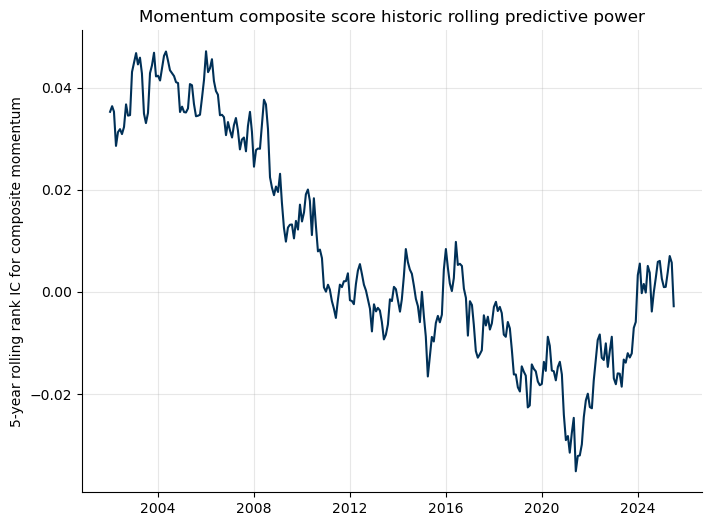

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(comp_ic_df['date'], comp_ic_df['rolling_ic'], color = gs_colors[0])
sns.despine()
plt.grid(alpha=0.3)
plt.ylabel('5-year rolling rank IC for composite momentum')
plt.title('Momentum composite score historic rolling predictive power')

In [85]:
momentum_composite = returns_and_const[['date', 'ticker', 'mom_comp']].rename(columns = {'mom_comp': 'score'})
momentum_composite['style'] = 'MOMENTUM'

In [86]:
momentum_composite.to_sql('factor_composites', psql, if_exists='append', index=False)

876